In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from utils import load_nerl_data, get_normalized_adj, get_Laplace, calculate_random_walk_matrix,test_error_cap,test_error
import random
import copy
import scipy
from scipy.io import loadmat
import math
import pandas as pd
from basic_structure import D_GCN, C_GCN, K_GCN,IGNNK
from basic_process import *
from sklearn.manifold import TSNE

2023-12-05 15:40:30.288847: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 15:40:30.313104: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 15:40:30.645164: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Define the parameter for NREL case

In [7]:
n_o_n_m = 20 #sampled space dimension

h = 24 #sampled time dimension

z = 100 #hidden dimension for graph convolution

K = 1 #If using diffusion convolution, the actual diffusion convolution step is K+1

n_m = 20 #number of mask node during training

N_u = 20 #target locations, N_u locations will be deleted from the training data

Max_episode = 750 #max training episode

learning_rate = 0.0001 #the learning_rate for Adam optimizer

batch_size = 8

E_maxvalue=80

STmodel = IGNNK(h, z, K)
STmodel.load_state_dict(torch.load('model/IGNNK_ushcn_750iter_2023-11-26 12:25:53.pth')) 

<All keys matched successfully>

In [8]:
X_raw=np.load('data/NDBC/all.npy')
#Raw data and raw adjacency matrix without mapminmax
X_raw=np.load('data/NDBC/all.npy')
# X_raw=normalize_3d_array(X_raw)
Station_info=pd.read_csv('data/NDBC/Station_info.csv')
NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
Adj_dist=adj_dist(NDBC_lat,NDBC_long)
Station_info=pd.read_csv('data/NDBC/Station_info.csv')
NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
Adj_dist=adj_dist(NDBC_lat,NDBC_long)
j=5#J-th colum, start from 5 as the first feature.
X_raw_0=X_raw[:,j,:]#GET the first feature
print(X_raw_0.shape)
# Count the num of missing values in each column
missing_counts_per_column = np.sum(np.isnan(X_raw_0), axis=0)
# print results
print("Incomplete data number in each column：", missing_counts_per_column)

#Get the index if the value is not zero
# Find the columns where missing values exist.
columns_with_missing_data = np.any(np.isnan(X_raw_0), axis=0)

# Get the column numbers when missing value exist.
missing_columns = np.where(columns_with_missing_data)[0]

# Print results
print("The column numbers with missing values are：", missing_columns)

#Get new data after deletion.
#Delete those columns(Stations) if there is not any features.
result = np.delete(X_raw_0, missing_columns, axis=1)
result = (result - np.min(result)) / (np.max(result) - np.min(result))
#Get new adjacency matrix after deletion.
NDBC_long=NDBC_long.transpose()
NDBC_long_aft=NDBC_long.drop(columns=missing_columns)
# Reconstruct the index in the DataFrame and get the longitude after deletion.
NDBC_long_aft = NDBC_long_aft.reset_index(drop=True)
print(NDBC_long_aft.shape)

NDBC_lat=NDBC_lat.transpose()
NDBC_lat_aft=NDBC_lat.drop(columns=missing_columns)
# Reconstruct the index in the DataFrame and get the latitude after deletion.
NDBC_lat_aft = NDBC_lat_aft.reset_index(drop=True)
print(NDBC_lat_aft.shape)
#GEt the new ADJ matrix.
Adj_dist=adj_dist(NDBC_lat_aft.transpose(),NDBC_long_aft.transpose())


capacities=np.ones((Adj_dist.shape[0], 1))
capacities=capacities.flatten()
split_line1 = int(result.shape[0] * 0.7)
training_set = result[:split_line1, :]
test_set = result[split_line1:, :]  
rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
unknow_set = rand.choice(list(range(0,result.shape[1])),N_u,replace=False)#Stations to be predicted
unknow_set = set(unknow_set)
full_set = set(range(0,result.shape[1]))
know_set = full_set - unknow_set
training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
A_s = Adj_dist[:, list(know_set)][list(know_set), :] 
MAE_t, RMSE_t, R2_t, nrel_ignnk_res  = test_error_cap(STmodel, unknow_set, full_set,test_set, Adj_dist,h,capacities)
#MAE_t, RMSE_t, R2_t, nrel_ignnk_res  = test_error(STmodel, unknow_set, test_set, A_s,E_maxvalue, True)
print('Best model in the',j, '-th column is', MAE_t, RMSE_t, R2_t)

(8784, 103)
Incomplete data number in each column： [8784    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0 8784    0    0    0 8784    0    0    0
    0    0    0    0    0    0    0 8784 8784    0    0    0    0 8784
 8784    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 8784    0    0    0    0    0    0    0 8784    0 8784
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
The column numbers with missing values are： [ 0 34 38 49 50 55 56 73 81 83]
(1, 93)
(1, 93)
Best model in the 5 -th column is 0.4317061864399936 0.550900953156517 -2.285412735056316


In [9]:
import numpy as np
#Subgraph generation module 1 --->Giving raw series, and generate a series of subgraph based on MI.

group_num=19
result
NDBC_lat_aft
NDBC_long_aft
MI_store=[]
for i in range(result.shape[1]):
    for j in range(result.shape[1]):
        MI_store.append(calc_MI(result[:,i],result[:,j],10))
MI_store=np.array(MI_store).reshape(result.shape[1],result.shape[1])

# 创建一个大小为(93, 93)的随机数组，你可以替换为你的实际数组
a = MI_store

# 对每一行的所有列元素进行排序，并返回最大的19个元素及其列号
max_elements_and_indices = []
for i in range(a.shape[0]):
    row = a[i, :]
    sorted_indices = np.argsort(row)
    max_indices = sorted_indices[-19:][::-1]  # 获取最大的19个元素的列号
    max_elements_and_indices.append([(row[j], j) for j in max_indices])

# 输出结果
for i, row_data in enumerate(max_elements_and_indices):
    print(f"Row {i}: {row_data}")




Row 0: [(3.253426176036873, 0), (0.8272601132894586, 1), (0.6901375697065202, 2), (0.4673606483958732, 4), (0.45757637448269683, 79), (0.4363240338301644, 5), (0.4190235175463517, 20), (0.37428008133733837, 3), (0.37263024544485734, 77), (0.33215728219304985, 21), (0.3299090634675217, 17), (0.3150689617867082, 83), (0.29292039446620866, 85), (0.22793155006306698, 78), (0.22350595260037576, 87), (0.2084899516681764, 91), (0.19725693559810153, 12), (0.16436438822998234, 15), (0.1621107642515911, 31)]
Row 1: [(3.2583097165163166, 1), (0.8272601132894577, 0), (0.5324618722588088, 20), (0.52600823699178, 2), (0.4273072620362397, 85), (0.4023069759074378, 21), (0.39111917114037187, 77), (0.34043212687770286, 4), (0.33742367205695434, 79), (0.3283135513911546, 17), (0.32209271522604777, 5), (0.3192857717713018, 91), (0.3012243820649747, 87), (0.2950417871731199, 83), (0.25018137359531334, 3), (0.2344515509245717, 11), (0.23100847367209631, 15), (0.22954525563754213, 12), (0.22306577157731855,

[3.253426176036873, 0.8272601132894586, 0.6901375697065202, 0.37428008133733837, 0.4673606483958732, 0.4363240338301644, 0.046592913203229, 0.047727363031481396, 0.06869053966721506, 0.04911468770996752, 0.10125880394889375, 0.15513395543730368, 0.19725693559810153, 0.0779097501756647, 0.05562693284596243, 0.16436438822998234, 0.10173701560948789, 0.3299090634675217, 0.06937049801544504, 0.13409996608400565, 0.4190235175463517, 0.33215728219304985, 0.07596636122032496, 0.0663126749581755, 0.06575943129935524, 0.032893311816365234, 0.03443837729989063, 0.04655558055076092, 0.056444669458780794, 0.06576826886766707, 0.10962686909974106, 0.1621107642515911, 0.07772961987272176, 0.0966457877057838, 0.08750394746818291, 0.11361591888716127, 0.06656537960473585, 0.0645586698775249, 0.05890813572238773, 0.06376207874312101, 0.0596632585699135, 0.06665335877298872, 0.08872664637913985, 0.13586993979589845, 0.12631372813239938, 0.03681098617994749, 0.07681250087322766, 0.03807595166325228, 0.03

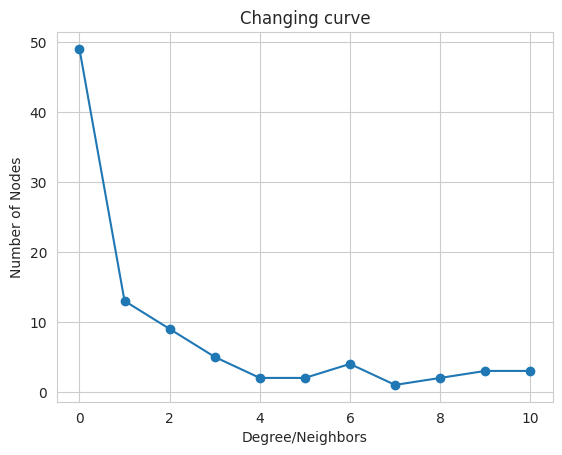

In [10]:
MI_All=[]
for i in range(result.shape[1]):
    for j in range(result.shape[1]):
        MI_All.append(calc_MI(result[:,i],result[:,j],10))
print(MI_All)
MI_All=np.array(MI_All).reshape(result.shape[1],result.shape[1])
np.fill_diagonal(MI_All, 0)
print(MI_All)
average_value = np.mean(MI_All)
count_per_column = np.sum(MI_All>(average_value+0.5), axis=0)

print("每列大于{}的元素数量：".format(average_value))
print(count_per_column)

# 如果需要将结果保存到新的数组中，可以使用以下代码：
result_array = np.array(count_per_column)

# 打印保存结果的数组
print("保存结果的数组：")
print(result_array)

import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# 使用Counter统计每个元素的数量
counter = Counter(result_array)

# 按照元素递增的顺序排序
sorted_items = sorted(counter.items())

# 提取元素和对应的数量
elements, counts = zip(*sorted_items)

# 绘制曲线
plt.plot(range(len(elements)), counts, marker='o')
plt.xlabel('Degree/Neighbors')
plt.ylabel('Number of Nodes')
plt.title('Changing curve')
plt.show()

In [11]:
#Adj---Determined by tSNE
#Raw data and raw adjacency matrix without mapminmax
X_raw=np.load('data/NDBC/all.npy')
# X_raw=normalize_3d_array(X_raw)

for j in range(5,X_raw.shape[1]):
        Station_info=pd.read_csv('data/NDBC/Station_info.csv')
        NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
        NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
        NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
        Adj_dist=adj_dist(NDBC_lat,NDBC_long)
        Station_info=pd.read_csv('data/NDBC/Station_info.csv')
        NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
        NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
        NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
        Adj_dist=adj_dist(NDBC_lat,NDBC_long)
        X_raw_0=X_raw[:,j,:]#GET the first feature
        #print(X_raw_0.shape)
        # Count the num of missing values in each column
        missing_counts_per_column = np.sum(np.isnan(X_raw_0), axis=0)
        # print results
       # print("Incomplete data number in each column：", missing_counts_per_column)
        
        #Get the index if the value is not zero
        # Find the columns where missing values exist.
        columns_with_missing_data = np.any(np.isnan(X_raw_0), axis=0)
        
        # Get the column numbers when missing value exist.
        missing_columns = np.where(columns_with_missing_data)[0]
        
        # Print results
        #print("The column numbers with missing values are：", missing_columns)
        
        #Get new data after deletion.
        #Delete those columns(Stations) if there is not any features.
        result = np.delete(X_raw_0, missing_columns, axis=1)
        result = (result - np.min(result)) / (np.max(result) - np.min(result))
        #Mean results---for SNE
        mean_result_axis_1=np.mean(result,axis=0)
        mean_result_axis_1=mean_result_axis_1.reshape(-1,1)
        
        #Get new adjacency matrix after deletion.
        NDBC_long=NDBC_long.transpose()
        NDBC_long_aft=NDBC_long.drop(columns=missing_columns)
        # Reconstruct the index in the DataFrame and get the longitude after deletion.
        NDBC_long_aft = NDBC_long_aft.reset_index(drop=True)
        print(NDBC_long_aft.shape)
        Temp_long=NDBC_long_aft.values
        
        NDBC_lat=NDBC_lat.transpose()
        NDBC_lat_aft=NDBC_lat.drop(columns=missing_columns)
        # Reconstruct the index in the DataFrame and get the latitude after deletion.
        NDBC_lat_aft = NDBC_lat_aft.reset_index(drop=True)
        print(NDBC_lat_aft.shape)
        Temp_lat=NDBC_lat_aft.values
        
        merged_array = np.concatenate([mean_result_axis_1, Temp_long.T,Temp_lat.T], axis=1)
        tsne = TSNE(n_components=2, random_state=30,perplexity=1) #Make sure random seed to be the same for the reproducibility.
        array_aft = tsne.fit_transform(merged_array)
        
        #GEt the new ADJ matrix.
        Adj_dist=adj_dist(pd.DataFrame(array_aft[:,0]),pd.DataFrame(array_aft[:,1]))
        capacities=np.ones((Adj_dist.shape[0], 1))
        capacities=capacities.flatten()
        split_line1 = int(result.shape[0] * 0.7)
        training_set = result[:split_line1, :]
        test_set = result[split_line1:, :]  
        rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
        unknow_set = rand.choice(list(range(0,result.shape[1])),N_u,replace=True)#Stations to be predicted
        unknow_set = set(unknow_set)
        full_set = set(range(0,result.shape[1]))
        know_set = full_set - unknow_set
        training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
        A_s = Adj_dist[:, list(know_set)][list(know_set), :] 
        MAE_t, RMSE_t, R2_t, nrel_ignnk_res  = test_error_cap(STmodel, unknow_set, full_set,test_set, Adj_dist,h,capacities)
        print('Best model in the',j, '-th column is', MAE_t, RMSE_t, R2_t)

(1, 93)
(1, 93)
Best model in the 5 -th column is 0.4313204183628211 0.5492192880111435 -2.3575093312006885
(1, 96)
(1, 96)
Best model in the 6 -th column is 0.1605222240853584 0.20509468000768996 -2.4120573020857967
(1, 94)
(1, 94)
Best model in the 7 -th column is 0.11271049741485661 0.14903063268355285 -2.309333356965407
(1, 72)
(1, 72)
Best model in the 8 -th column is 0.08222698975091797 0.11246212961834812 -1.3070648654887838
(1, 72)
(1, 72)
Best model in the 9 -th column is 0.2481887797347075 0.3217597406157303 -3.4879309515223174
(1, 65)
(1, 65)
Best model in the 10 -th column is 0.13582240806571927 0.17558368157676468 -3.5208471514608313
(1, 40)
(1, 40)
Best model in the 11 -th column is 0.4204369127702716 0.5335969818335619 -2.130453390355077
(1, 98)
(1, 98)
Best model in the 12 -th column is 0.03946403678994369 0.053248833393704155 -16.233845987071604
(1, 99)
(1, 99)
Best model in the 13 -th column is 0.5732571312506446 0.719970364160424 -47.88267969609573
(1, 77)
(1, 77)
Be

ValueError: zero-size array to reduction operation minimum which has no identity

In [12]:
##Non- TSNE

#Raw data and raw adjacency matrix without mapminmax
X_raw=np.load('data/NDBC/all.npy')
# X_raw=normalize_3d_array(X_raw)

for j in range(5,X_raw.shape[1]):
        Station_info=pd.read_csv('data/NDBC/Station_info.csv')
        NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
        NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
        NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
        Adj_dist=adj_dist(NDBC_lat,NDBC_long)
        Station_info=pd.read_csv('data/NDBC/Station_info.csv')
        NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
        NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
        NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
        Adj_dist=adj_dist(NDBC_lat,NDBC_long)
        X_raw_0=X_raw[:,j,:]#GET the first feature
        #print(X_raw_0.shape)
        # Count the num of missing values in each column
        missing_counts_per_column = np.sum(np.isnan(X_raw_0), axis=0)
        # print results
       # print("Incomplete data number in each column：", missing_counts_per_column)
        
        #Get the index if the value is not zero
        # Find the columns where missing values exist.
        columns_with_missing_data = np.any(np.isnan(X_raw_0), axis=0)
        
        # Get the column numbers when missing value exist.
        missing_columns = np.where(columns_with_missing_data)[0]
        
        # Print results
        #print("The column numbers with missing values are：", missing_columns)
        
        #Get new data after deletion.
        #Delete those columns(Stations) if there is not any features.
        result = np.delete(X_raw_0, missing_columns, axis=1)
        result = (result - np.min(result)) / (np.max(result) - np.min(result))
        #Mean results---for SNE
        mean_result_axis_1=np.mean(result,axis=0)
        mean_result_axis_1=mean_result_axis_1.reshape(-1,1)
        
        #Get new adjacency matrix after deletion.
        NDBC_long=NDBC_long.transpose()
        NDBC_long_aft=NDBC_long.drop(columns=missing_columns)
        # Reconstruct the index in the DataFrame and get the longitude after deletion.
        NDBC_long_aft = NDBC_long_aft.reset_index(drop=True)
        print(NDBC_long_aft.shape)
        Temp_long=NDBC_long_aft.values
        
        NDBC_lat=NDBC_lat.transpose()
        NDBC_lat_aft=NDBC_lat.drop(columns=missing_columns)
        # Reconstruct the index in the DataFrame and get the latitude after deletion.
        NDBC_lat_aft = NDBC_lat_aft.reset_index(drop=True)
        print(NDBC_lat_aft.shape)
        Temp_lat=NDBC_lat_aft.values
        
        merged_array = np.concatenate([mean_result_axis_1, Temp_long.T,Temp_lat.T], axis=1)
        tsne = TSNE(n_components=2, random_state=30,perplexity=1) #Make sure random seed to be the same for the reproducibility.
        array_aft = tsne.fit_transform(merged_array)
        
        #GEt the new ADJ matrix.
        Adj_dist=adj_dist(pd.DataFrame(array_aft[:,0]),pd.DataFrame(array_aft[:,1]))
        capacities=np.ones((Adj_dist.shape[0], 1))
        capacities=capacities.flatten()
        split_line1 = int(result.shape[0] * 0.7)
        training_set = result[:split_line1, :]
        test_set = result[split_line1:, :]  
        rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
        unknow_set = rand.choice(list(range(0,result.shape[1])),N_u,replace=True)#Stations to be predicted
        unknow_set = set(unknow_set)
        full_set = set(range(0,result.shape[1]))
        know_set = full_set - unknow_set
        training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
        A_s = Adj_dist[:, list(know_set)][list(know_set), :] 
        MAE_t, RMSE_t, R2_t, nrel_ignnk_res  = test_error_cap(STmodel, unknow_set, full_set,test_set, Adj_dist,h,capacities)
        print('Best model in the',j, '-th column is', MAE_t, RMSE_t, R2_t)

7

In [43]:
##Non- TSNE

#Raw data and raw adjacency matrix without mapminmax
X_raw=np.load('data/NDBC/all.npy')
# X_raw=normalize_3d_array(X_raw)
for j in range(5,X_raw.shape[1]):
    Station_info=pd.read_csv('data/NDBC/Station_info.csv')
    NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
    NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
    NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
    Adj_dist=adj_dist(NDBC_lat,NDBC_long)
    Station_info=pd.read_csv('data/NDBC/Station_info.csv')
    NDBC_lat=pd.DataFrame(Station_info.iloc[:,1])
    NDBC_long=pd.DataFrame(Station_info.iloc[:,3])
    NDBC_ID=pd.DataFrame(Station_info.iloc[:,0])
    Adj_dist=adj_dist(NDBC_lat,NDBC_long)
    X_raw_0=X_raw[:,j,:]#GET the first feature
    #print(X_raw_0.shape)
    # Count the num of missing values in each column
    missing_counts_per_column = np.sum(np.isnan(X_raw_0), axis=0)
    # print results
    # print("Incomplete data number in each column：", missing_counts_per_column)
    
    #Get the index if the value is not zero
    # Find the columns where missing values exist.
    columns_with_missing_data = np.any(np.isnan(X_raw_0), axis=0)
    
    # Get the column numbers when missing value exist.
    missing_columns = np.where(columns_with_missing_data)[0]
    
    # Print results
    #print("The column numbers with missing values are：", missing_columns)
    
    #Get new data after deletion.
    #Delete those columns(Stations) if there is not any features.
    result = np.delete(X_raw_0, missing_columns, axis=1)
    result = (result - np.min(result)) / (np.max(result) - np.min(result))
    #Mean results---for SNE
    mean_result_axis_1=np.mean(result,axis=0)
    mean_result_axis_1=mean_result_axis_1.reshape(-1,1)
    
    #Get new adjacency matrix after deletion.
    NDBC_long=NDBC_long.transpose()
    NDBC_long_aft=NDBC_long.drop(columns=missing_columns)
    # Reconstruct the index in the DataFrame and get the longitude after deletion.
    NDBC_long_aft = NDBC_long_aft.reset_index(drop=True)
    print(NDBC_long_aft.shape)
    Temp_long=NDBC_long_aft.values
    
    NDBC_lat=NDBC_lat.transpose()
    NDBC_lat_aft=NDBC_lat.drop(columns=missing_columns)
    # Reconstruct the index in the DataFrame and get the latitude after deletion.
    NDBC_lat_aft = NDBC_lat_aft.reset_index(drop=True)
    print(NDBC_lat_aft.shape)
    Temp_lat=NDBC_lat_aft.values
    
    merged_array = np.concatenate([mean_result_axis_1, Temp_long.T,Temp_lat.T], axis=1)
    tsne = TSNE(n_components=2, random_state=30,perplexity=1) #Make sure random seed to be the same for the reproducibility.
    array_aft = tsne.fit_transform(merged_array)
    NDBC_lat_aft_trans=NDBC_lat_aft.transpose()
    NDBC_long_aft_trans=NDBC_long_aft.transpose()
    Adj_dist=adj_dist(NDBC_lat_aft_trans,NDBC_long_aft_trans)
    capacities=np.ones((Adj_dist.shape[0], 1))
    capacities=capacities.flatten()
    split_line1 = int(result.shape[0] * 0.7)
    training_set = result[:split_line1, :]
    test_set = result[split_line1:, :]  
    rand = np.random.RandomState(0) # Fixed random output, just an example when seed = 0.
    unknow_set = rand.choice(list(range(0,result.shape[1])),N_u,replace=True)#Stations to be predicted
    unknow_set = set(unknow_set)
    full_set = set(range(0,result.shape[1]))
    know_set = full_set - unknow_set
    training_set_s = training_set[:, list(know_set)]   # get the training data in the sample time period
    A_s = Adj_dist[:, list(know_set)][list(know_set), :] 
    MAE_t, RMSE_t, R2_t, nrel_ignnk_res  = test_error_cap(STmodel, unknow_set, full_set,test_set, Adj_dist,h,capacities)
    print('Best model in the',j, '-th column is', MAE_t, RMSE_t, R2_t)

(1, 93)
(1, 93)
Best model in the 5 -th column is 0.5593098287391837 0.6751070000373451 -4.073070397802377
(1, 96)
(1, 96)
Best model in the 6 -th column is 0.2165852095906664 0.2571515949809025 -4.363965431222136
(1, 94)
(1, 94)
Best model in the 7 -th column is 0.15980378189365185 0.19272325052254985 -4.534235686232873
(1, 72)
(1, 72)
Best model in the 8 -th column is 0.11869336867515397 0.14807829309868978 -2.9997237631300764
(1, 72)
(1, 72)
Best model in the 9 -th column is 0.34495108423475446 0.40305175929852843 -6.042135910779267
(1, 65)
(1, 65)
Best model in the 10 -th column is 0.19639672486415288 0.22956576806564288 -6.727976248871831
(1, 40)
(1, 40)
Best model in the 11 -th column is 0.5398313571510523 0.6564544211990725 -3.7379412184205103
(1, 98)
(1, 98)
Best model in the 12 -th column is 0.0727824197879286 0.08348243024964898 -41.35963206510541
(1, 99)
(1, 99)
Best model in the 13 -th column is 0.8426121635539087 0.9585772504815465 -85.65228130116977
(1, 77)
(1, 77)
Best m

ValueError: zero-size array to reduction operation minimum which has no identity

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 生成一些三维数据作为例子
np.random.seed(42)
data_3d = np.random.rand(93,3)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42,perplexity=30) #Make sure random seed to be the same for the reproducibility.
data_2d = tsne.fit_transform(data_3d)

# 绘制结果
plt.scatter(data_2d[:, 0], data_2d[:, 1])
plt.title('t-SNE Projection of 3D Data to 2D')
plt.show()
data_2d[:,0].shape


import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 生成一些三维数据作为例子
np.random.seed(42)
data_3d = np.random.rand(93, 3)

# 使用t-SNE进行降维
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
data_2d = tsne.fit_transform(data_3d)

# 找到y值最高、第20高和第18高的点的索引
max_y_index = np.argmax(data_2d[:, 1])
twentieth_max_y_index = np.argsort(data_2d[:, 1])[-20]
eighteenth_y_index = np.argsort(data_2d[:, 1])[-18]

# 绘制结果
plt.scatter(data_2d[:, 0], data_2d[:, 1])

# 将y值最高的点变为红色
plt.scatter(data_2d[max_y_index, 0], data_2d[max_y_index, 1], color='red', label='High corr 2')

# 将y值排第20的点变为红色
plt.scatter(data_2d[twentieth_max_y_index, 0], data_2d[twentieth_max_y_index, 1], color='red', label='High corr 1')

# 将y值排第18的点变为绿色
plt.scatter(data_2d[eighteenth_y_index, 0], data_2d[eighteenth_y_index, 1], color='green', label='Low corr')

plt.title('t-SNE Projection of 3D Data to 2D')
plt.legend()
plt.show()

In [41]:
#GEt the new ADJ matrix.


Best model in the 5 -th column is 0.5593098287391837 0.6751070000373451 -4.073070397802377


Load data

As we further explored IGNNK, we found that adjacency matrix definition is crucial for the performance of GNN traning. Especially in the definition of sigma in Gaussian kernel based adjacency. Here we use a Gaussian Process based method to find an optimal sigma. 

Output the result from the best IGNNK model